In [1]:
#   Are we using a GPU?
!nvidia-smi

Wed Apr 24 07:57:56 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   57C    P8              12W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

Downloading and becoming one with the data

In [2]:
#How many images in each folder?
import os

for dirpath, dirnames, filenames in os.walk("/content/drive/MyDrive/CDD-CESM_Benign_Malignant"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 2 directories and 0 images in '/content/drive/MyDrive/CDD-CESM_Benign_Malignant'.
There are 2 directories and 0 images in '/content/drive/MyDrive/CDD-CESM_Benign_Malignant/Train'.
There are 0 directories and 487 images in '/content/drive/MyDrive/CDD-CESM_Benign_Malignant/Train/Benign'.
There are 0 directories and 562 images in '/content/drive/MyDrive/CDD-CESM_Benign_Malignant/Train/Malignant'.
There are 2 directories and 0 images in '/content/drive/MyDrive/CDD-CESM_Benign_Malignant/Test'.
There are 0 directories and 100 images in '/content/drive/MyDrive/CDD-CESM_Benign_Malignant/Test/Malignant'.
There are 0 directories and 100 images in '/content/drive/MyDrive/CDD-CESM_Benign_Malignant/Test/Benign'.


##Creating  data loaders (preparing the data)
we will use the ImageDataGenerator class to load in our images batches

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SHAPE = (224, 224)
BATCH_SIZE = 32

train_dir = "/content/drive/MyDrive/CDD-CESM_Benign_Malignant/Train"
test_dir = "/content/drive/MyDrive/CDD-CESM_Benign_Malignant/Test/"

train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

print("Training images:")
train_data_cancer = train_datagen.flow_from_directory(train_dir,
                                               target_size=IMAGE_SHAPE,
                                               batch_size=BATCH_SIZE,
                                               class_mode="binary")

print("Testing images:")
test_data_cancer = test_datagen.flow_from_directory(test_dir,
                                              target_size=IMAGE_SHAPE,
                                              batch_size=BATCH_SIZE,
                                              class_mode="binary")

Training images:
Found 1049 images belonging to 2 classes.
Testing images:
Found 200 images belonging to 2 classes.


### Setting up callbacks (things to run whilst our model trains)

Callbacks are extra functionality you can add to your models to be performed during or after training. Some of the most popular callbacks:

*Tracking expriments with the TensorBoard callback
*Model checkpoint with the ModelCheckpoint callback
*Stopping a model from training (before it trains too long and overfits) with the EarlyStopping callback

In [4]:
#Create TensorBoard callback (functionized because we need to create a new one for each model)
import datetime

def create_tensorboard_callback(dir_name,experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(
      log_dir=log_dir
  )
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback

# Creating Models using Tensorflow Hub
In the past we've used Tensorflow to create our own models layer by layer from scratch.

Now we are going to do a similar process, except the majority of our model's layer are going to come from Tensorflow Hub.

We can access pretrained models on https://www.tensorflow.org/hub

Browsing the TensorFlow Hub page anf sorting for image classification, we found the following feature vector model link: https://www.kaggle.com/models/tensorflow/efficientnet/tensorFlow2/b0-feature-vector/1?tfhub-redirect=true


In [6]:
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4"

efficientnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

In [7]:
#import depencencies
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

In [8]:
IMAGE_SHAPE+(3,)

(224, 224, 3)

In [21]:
#let's make a create_model() function to create a model from a URL
def create_model(model_url,num_classes=2):
  """
  Takes a Tensorflow Hub URL and creates a Keras Sequential model with it.

  Args:
    model_url (str): A Tensorflow Hub feature extraction URL.
    num_classes (int): Number of output neurons in the output layer,
      should be equal to the number of target classes, default 10.

  Returns:
    An uncompiled Keras Sequential model with model_url as feature
    extractor layer and Dense output layer with num_classes outputs.
  """
  # Download the pretrained model and save it as a Keras Layer
  feature_extractor_layer = hub.KerasLayer(model_url,
                                           trainable=False, # freeze the already learned patterns
                                           name='feature_extraction_layer',
                                           input_shape=IMAGE_SHAPE+(3,)) # define the input image shape

  #Create our own model
  model = tf.keras.Sequential([
    feature_extractor_layer,
    layers.Dense(num_classes, activation='softmax',name ="output_layer")
  ])
  return model


### Creating and testing ResNet TensorFlow Hub Extraction model

In [22]:
#Create ResNet Model

resnet_model = create_model(resnet_url, train_data_cancer.num_classes)


In [23]:
#compile our resnet model
resnet_model.compile(loss="binary_crossentropy",
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=["accuracy"])

In [24]:
resnet_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (  (None, 2048)              23564800  
 KerasLayer)                                                     
                                                                 
 output_layer (Dense)        (None, 2)                 4098      
                                                                 
Total params: 23568898 (89.91 MB)
Trainable params: 4098 (16.01 KB)
Non-trainable params: 23564800 (89.89 MB)
_________________________________________________________________


In [25]:
print(train_data_cancer.labels.shape)
print(test_data_cancer.labels.shape)

(1049,)
(200,)


In [28]:
resnet_model.add(tf.keras.layers.Dense(1, activation="sigmoid"))

In [30]:
#Let's fit our ResNet model to the data
resnet_history = resnet_model.fit(train_data_cancer,
                                  epochs=50,
                                  steps_per_epoch=len(train_data_cancer),
                                  validation_data=test_data_cancer,
                                  validation_steps=len(test_data_cancer),
                                  callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",
                                                                         experiment_name="resnet50V2")])

Saving TensorBoard log files to: tensorflow_hub/resnet50V2/20240424-104652
Epoch 1/50
33/33 [==============================] - 30s 902ms/step - loss: 0.6969 - accuracy: 0.4643 - val_loss: 0.6936 - val_accuracy: 0.5000
Epoch 2/50
33/33 [==============================] - 31s 947ms/step - loss: 0.6953 - accuracy: 0.4643 - val_loss: 0.6934 - val_accuracy: 0.5000
Epoch 3/50
33/33 [==============================] - 31s 940ms/step - loss: 0.6942 - accuracy: 0.4643 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 4/50
33/33 [==============================] - 30s 914ms/step - loss: 0.6932 - accuracy: 0.4909 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 5/50
33/33 [==============================] - 30s 907ms/step - loss: 0.6925 - accuracy: 0.5357 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 6/50
33/33 [==============================] - 29s 892ms/step - loss: 0.6921 - accuracy: 0.5357 - val_loss: 0.6934 - val_accuracy: 0.5000
Epoch 7/50
33/33 [==============================] - 29s 888ms/step 

In [31]:
#Let's create a function to plot our loss curves

import matplotlib.pyplot as plt

def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.
  Args:
    history: TensorFlow History object.

    Returns:
    Plots of training/validation loss and accuracy metrics.
  """
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  #Plot loss

  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  #Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

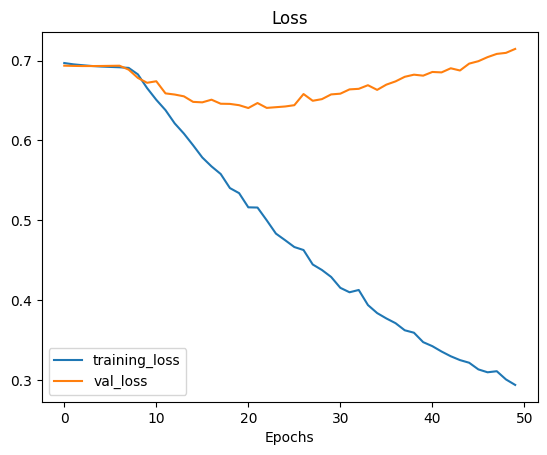

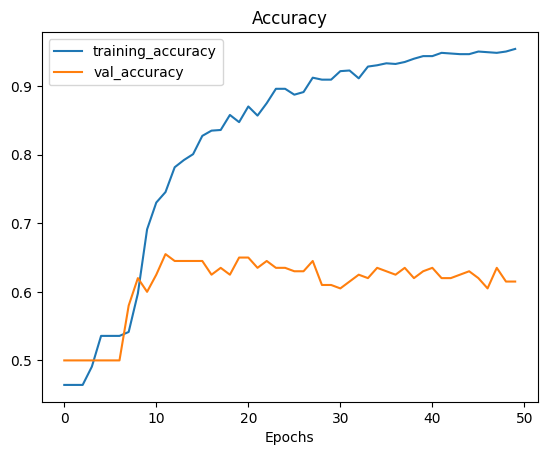

In [32]:
plot_loss_curves(resnet_history)